In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [2]:
train_data = pd.read_csv('train_cleaned.csv')

In [3]:
y = train_data.iloc[:, :1].values

In [4]:
def model_score(key):
    print(key)

    # train_test_split
    x = train_data.iloc[:, 1:]
    if(len(key) > 0):
        x = x.drop(columns=[key])
        x = x.values
        
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

    # scaler
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    # k-value
    error_rate=[]
    for i in range (1,31):
        clf=KNeighborsClassifier(n_neighbors=i)
        clf.fit(x_train,y_train.ravel())
        predict_i=clf.predict(x_test)
        error_rate.append(1 - accuracy_score(y_test, predict_i))
    k_value = error_rate.index(min(error_rate)) + 1

    # prepare models
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier(n_neighbors=k_value)))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC()))

    # evaluate each model in turn
    dict = {}
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5)
        cv_results = model_selection.cross_val_score(model, x_train, y_train.ravel(), cv=kfold, scoring='accuracy')
        dict[name] = [cv_results.mean(), cv_results.std()]

    return dict

In [5]:
results = {}

In [6]:
for key in train_data.columns[1:]:
    results[key] = pd.DataFrame(model_score(key))

Pclass
Age
SibSp
Parch
Fare
female
cabin_number
cabin_A
cabin_B
cabin_C
cabin_D
cabin_E
cabin_F
cabin_G
cabin_N
from_C
from_Q
from_S
missing_age
friends_num
has_relative
Title_Miss
Title_Mr
Title_Mrs
Title_honorary_title


In [7]:
full_dataset_result = pd.DataFrame(model_score(''))
full_dataset_result

,LR,LDA,KNN,CART,NB,SVM
0,0.810342,0.814577,0.806107,0.762681,0.747129,0.834236
1,0.032639,0.035599,0.049551,0.017407,0.031920,0.028162


In [8]:
results['Pclass']

,LR,LDA,KNN,CART,NB,SVM
0,0.821609,0.817404,0.810332,0.785108,0.738708,0.820211
1,0.015994,0.021450,0.026359,0.030289,0.028773,0.018799


In [9]:
margins = {}

In [10]:
for key, res in results.items():
    tmp_dict = {}
    for model in res.columns:
        tmp_dict[model] = []
        tmp_dict[model].append(res[model][0] - full_dataset_result[model][0])
        tmp_dict[model].append(res[model][1] - full_dataset_result[model][1])

    margins[key] = pd.DataFrame(tmp_dict)

In [11]:
margins['Pclass']

,LR,LDA,KNN,CART,NB,SVM
0,0.011268,0.002827,0.004225,0.022427,-0.008421,-0.014025
1,-0.016646,-0.014149,-0.023192,0.012882,-0.003146,-0.009364


In [12]:
margins

margins_means = {}

for key, res in margins.items():
    for col in res.columns:
        margins_means[col] = {}
        for key2, res2 in margins.items():
            margins_means[col][key2] = margins[key2][col][0]

### Margins of Means Exploration

Greater margin means improvement in performance. A great margin implies that the exclusion of this variable lead to an increase in accuracy. A very small margin therefore implies that the exclusion of a variable leads to a decrease in accuracy.

#### Variable most accountable for accuracy loss

In [13]:
for model, res in margins_means.items():
    minimum = min(res, key=res.get)
    print(model, ':',minimum, '(',res[minimum], ')')

LR : Age ( -0.020900226534029454 )
LDA : female ( -0.021146459174628096 )
KNN : cabin_B ( -0.026671919629666196 )
CART : cabin_number ( -0.018349256377425238 )
NB : cabin_C ( -0.05473259135230957 )
SVM : female ( -0.0323746675859351 )


In [14]:
margins_df = pd.DataFrame(margins_means)
margins_df.index

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'female', 'cabin_number',
       'cabin_A', 'cabin_B', 'cabin_C', 'cabin_D', 'cabin_E', 'cabin_F',
       'cabin_G', 'cabin_N', 'from_C', 'from_Q', 'from_S', 'missing_age',
       'friends_num', 'has_relative', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_honorary_title'],
      dtype='object')

### Visualizations of most important variables

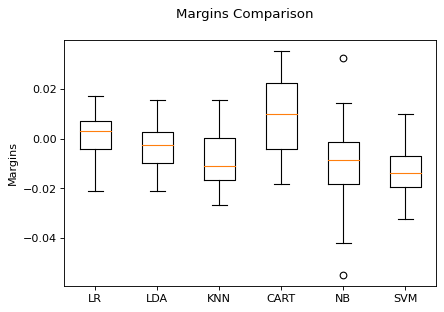

In [15]:
fig = plt.figure(figsize=(6, 4), dpi=80)
fig.suptitle('Margins Comparison')
ax = fig.add_subplot(111)
plt.boxplot(margins_df)
ax.set_xticklabels(margins_df.columns)
plt.ylabel('Margins')
plt.show()

#### Margins for attributes across Models

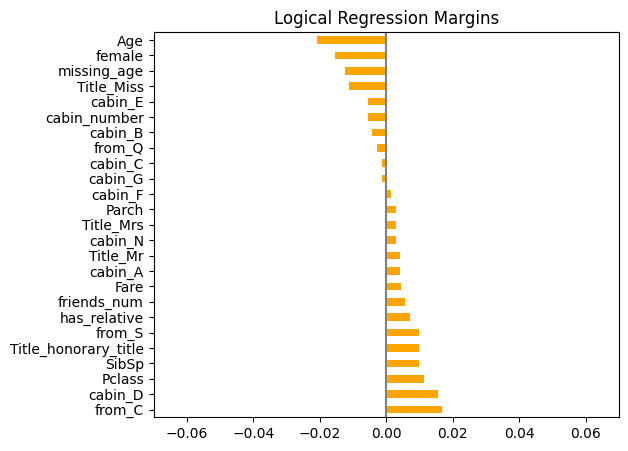

In [32]:
lr_margins = margins_df['LR']
lr_margins = lr_margins.reindex(lr_margins.sort_values(ascending=False).index)
ax = lr_margins.plot(kind='barh', figsize=(6, 5), color='orange')
plt.title('Logical Regression Margins')
plt.xlim(-0.07, 0.07)
plt.axvline(x=0, color='.5')

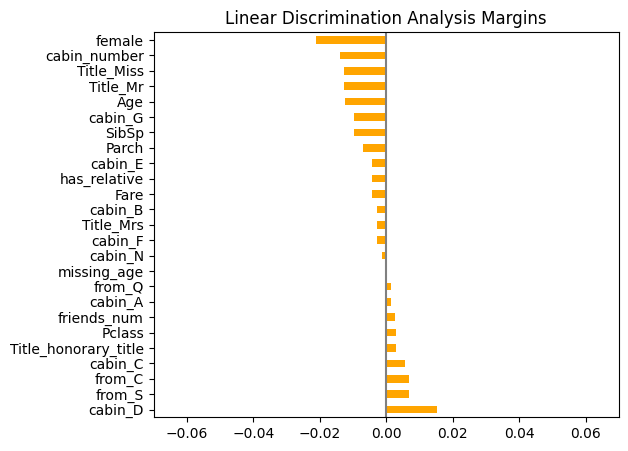

In [33]:
lda_margins = margins_df['LDA']
lda_margins = lda_margins.reindex(lda_margins.sort_values(ascending=False).index)
ax = lda_margins.plot(kind='barh', figsize=(6, 5), color='orange')
plt.title('Linear Discrimination Analysis Margins')
plt.xlim(-0.07, 0.07)
plt.axvline(x=0, color='.5')

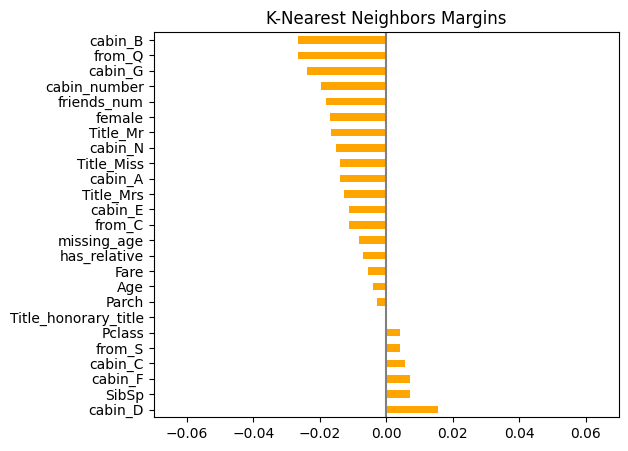

In [34]:
knn_margins = margins_df['KNN']
knn_margins = knn_margins.reindex(knn_margins.sort_values(ascending=False).index)
ax = knn_margins.plot(kind='barh', figsize=(6, 5), color='orange')
plt.title('K-Nearest Neighbors Margins')
plt.xlim(-0.07, 0.07)
plt.axvline(x=0, color='.5')

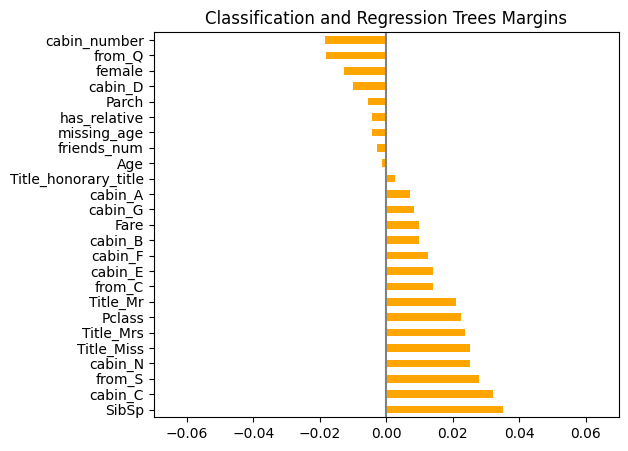

In [35]:
cart_margins = margins_df['CART']
cart_margins = cart_margins.reindex(cart_margins.sort_values(ascending=False).index)
ax = cart_margins.plot(kind='barh', figsize=(6, 5), color='orange')
plt.title('Classification and Regression Trees Margins')
plt.xlim(-0.07, 0.07)
plt.axvline(x=0, color='.5')

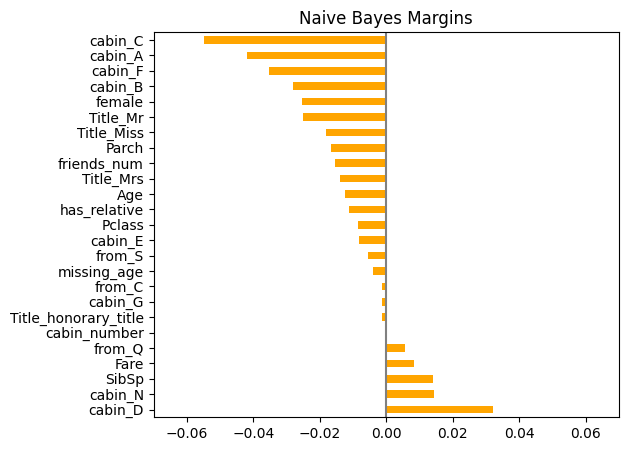

In [36]:
nb_margins = margins_df['NB']
nb_margins = nb_margins.reindex(nb_margins.sort_values(ascending=False).index)
ax = nb_margins.plot(kind='barh', figsize=(6, 5), color='orange')
plt.title('Naive Bayes Margins')
plt.xlim(-0.07, 0.07)
plt.axvline(x=0, color='.5')

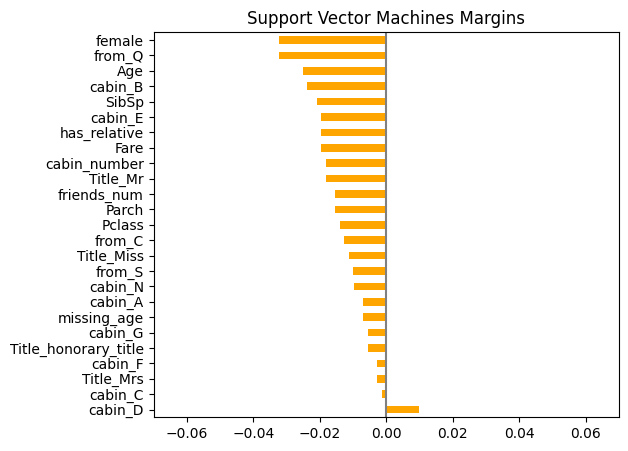

In [37]:
svm_margins = margins_df['SVM']
svm_margins = svm_margins.reindex(svm_margins.sort_values(ascending=False).index)
ax = svm_margins.plot(kind='barh', figsize=(6, 5), color='orange')
plt.title('Support Vector Machines Margins')
plt.xlim(-0.07, 0.07)
plt.axvline(x=0, color='.5')

### Always profitable / always deceiving variables

In [38]:
for i, j in margins_df.iterrows():
    if (j>0).all():
        print(i, 'always deceiving.')
    elif (j<0).all():
        print(i, 'always profitable.')
    else:
        print(i, 'ambiguos.')

Pclass ambiguos.
Age always profitable.
SibSp ambiguos.
Parch ambiguos.
Fare ambiguos.
female always profitable.
cabin_number ambiguos.
cabin_A ambiguos.
cabin_B ambiguos.
cabin_C ambiguos.
cabin_D ambiguos.
cabin_E ambiguos.
cabin_F ambiguos.
cabin_G ambiguos.
cabin_N ambiguos.
from_C ambiguos.
from_Q ambiguos.
from_S ambiguos.
missing_age ambiguos.
friends_num ambiguos.
has_relative ambiguos.
Title_Miss ambiguos.
Title_Mr ambiguos.
Title_Mrs ambiguos.
Title_honorary_title ambiguos.
